# Introduction

This chapter discusses the biochemical processes behind the information capabilities of the brain. Simulations in this chapter are based on sets of differential equations describing the voltage and conductance of the neuron membrane and the ion channels in them.

### Imports 

In [4]:
using DifferentialEquations
using Plots

# Excitatory Postsynaptic Potential 

When a presynaptic neuron releases neurotransmissors in a synapse, this induces a variation in the membrane potential in the postsynaptic neuron called _postsynaptic potential_. This variation is described by the _alpha function_, which is typically used to model chemical synapses. This alpha function, combined with difference of potential of the ions inside and outside the membrane induces a differential equation relating the voltage and the membrane leakage channel.

In [5]:
# define variables for the model 
struct EPSPModel
    capacitance :: Float64
    back_condutance :: Float64
    τ :: Float64
    back_potential :: Float64
    
    # default values
    function EPSPModel()
        new(1, 1, 1, 10)
    end
end

# and the equations based on those variables
function equations(model::EPSPModel)
    # f[1] = voltage, f[2] = condutance
    V = 1; C = 2
    
    function δ(x::Float64)
        abs(x) < 0.5 && return 1
        return 0
    end
    
    function diffeq(df, f, _, t)
        current = f[C] * (f[V] - model.back_potential)
        
        df[V] = - (1/model.capacitance) * (current + model.back_condutance * f[V]) 
        df[C] = (1/model.τ) * (-f[C] + δ(t-1))
    end
end
;

When we simulate this equations, we can see that membrane potential initially spikes when the neurotransmissor reaches the membrane and then gradually resets back to it's initial value

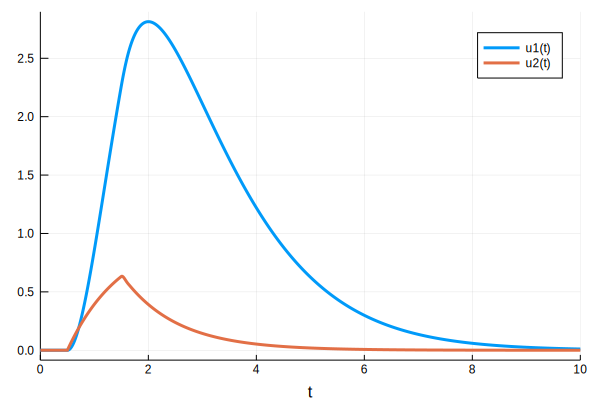

In [6]:
# instantiate a model, initial conditions, and boundaries
model = EPSPModel()
initial_conditions = [0.0, 0.0]
tspan = (0.0, 10.0)

# and solve
problem = ODEProblem(equations(model), initial_conditions, tspan)
solution = solve(problem)
plot(solution)

# The Hodgkin-Huxley Model

The previous equations show how neurotransmissors are able to cause a variation in the neuron membrane's potential. Combined with some other mechanisms, this ultimately leads to the generation of an _action potential_, a mechanism known to be key in neuronal communication and characterized by the quick increase and subsequent quick decrease of the membrane potential. 

Hodgkin and Huxley were the first to describe the dynamics of the mechanism in a set of differential equations. The minimal mechanisms of the model involve a voltage-dependent sodium channel. When these channels are activated due to voltage variations caused by postsynaptic potentials, this leads to an influx of sodium ions which shifts the membranes potential near +65mV. Then this leads to a block of these sodium channels, aswell as the activation of other voltage dependent potassium channels which lower the potential back to it's resting value by first undershotting and then stabilizing. These mechanism, coupled with the resting ion channel that mantains the rest potential, can be described in the following equations 

In [7]:
struct HHModel
    capacitance :: Float64
    
    potassium_base_condutance :: Float64
    sodium_base_condutance :: Float64
    back_condutance :: Float64
    
    potassium_potential :: Float64
    sodium_potential :: Float64
    back_potential :: Float64
    
    # default values
    function HHModel()
        new(2, 36, 120, 0.3, -12, 115, 10.613)
    end
end

function equations(model::HHModel)
    V=1; K=2; Na=3; L=4;
    
    function α(i, voltage::Float64)
        i == K  && return (10-voltage) / (100 * (exp((10 -voltage)/10)-1))
        i == Na && return (25-voltage) / (10 * (exp((25 -voltage)/10)-1))
        i == L  && return 0.07 * exp(-voltage/20)
    end
    
    function β(i, voltage::Float64)
        i == K  && return 0.125 * exp(-voltage/80)
        i == Na && return 4 * exp(-voltage/18)
        i == L  && return 1 / exp(((30-voltage)/10)+1)
    end
    
    function τ(i, voltage::Float64)
        1 / (α(i, voltage) + β(i, voltage))
    end
    
    function x₀(i, voltage::Float64)
        α(i, voltage) * τ(i, voltage)
    end
    
    function current(t)
        (t > 40 || t < 10) && return 0.
        return 10.
    end
    
    function diffequations(df, f, _, t)
        total_current = current(t)
        total_current -= model.potassium_base_condutance * (f[K] ^ 4) * (f[V] - model.potassium_potential)
        total_current -= model.sodium_base_condutance * (f[Na] ^ 3) * f[L] * (f[V] - model.sodium_potential)
        total_current -= model.back_condutance * (f[V] - model.back_potential)
        
        df[V] = (1/model.capacitance) * total_current
        df[K] = (-1/τ(K, f[V])) * (f[K] - x₀(K, f[V]))
        df[Na] = (-1/τ(Na, f[V])) * (f[Na] - x₀(Na, f[V]))
        df[L] = (-1/τ(L, f[V])) * (f[L] - x₀(L, f[V]))
    end
end
;

The simulation shows the depolarization that is quickly followed by a hyperpolarization

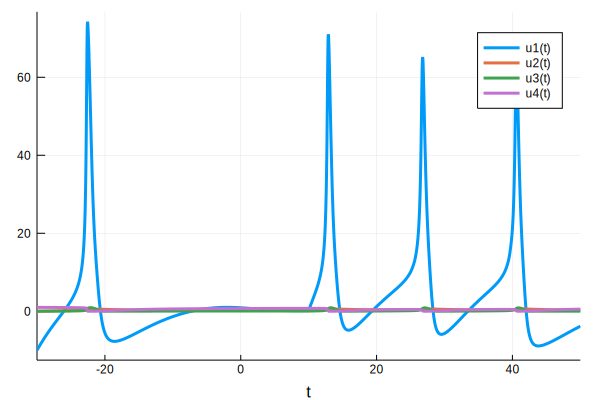

In [8]:
model = HHModel()
initial_conditions = [-10., 0., 0., 1.]
tspan = (-30.0, 50.0)

problem = ODEProblem(equations(model), initial_conditions, tspan)
solution = solve(problem, tspan=(0.0, 50.0), vars=([1]))
plot(solution)

# The Wilson Model

While Hodgkin-Huxley model is a good basic description of the action potential generation in neurons, more ion channels are involved in the mechanisms of more complex nervous systems that allow differentiation between neurons and more complex responses.

The Wilson models takes the Hodgkin-Huxley model one step forward by simpplyifing the mechanisms behind the previously described ion channels, but including two more ions channels, one for calcium and another for potassium. The mechanisms can be described by the following equations

In [9]:
struct WilsonModel
    capacitance :: Float64
    
    potassium_base_condutance :: Float64
    t_base_condutance :: Float64
    h_base_condutance :: Float64
    
    potassium_potential :: Float64
    sodium_potential :: Float64
    t_potential :: Float64
    h_potential :: Float64
    
    τ_R :: Float64
    τ_T :: Float64
    τ_H :: Float64
end

function Regular()
    WilsonModel(1, 26, 0.1, 5, -0.95, 0.5, 1.2, -0.95, 4.2, 14, 45)
end

function Bursting()
    WilsonModel(1, 26, 2.25, 9.5, -0.95, 0.5, 1.2, -0.95, 4.2, 14, 45)
end

function equations(model::WilsonModel)
    V=1; R=2; T=3; H=4;
    
    function sodium_condutance(voltage::Float64)
        17.8 + 47.6 * voltage + 33.8 * voltage^2
    end
    
    function current(t::Float64)
        t < 0 && return 0.
        return 1.
    end
    
    function x₀(i, voltage::Float64)
        i == R && return 1.24 + 3.7 * voltage + 3.2 * voltage ^2
        i == T && return 4.205 + 11.6 * voltage + 8 * voltage ^2
    end
    
    function diffequations(df, f, _, t)
        total_current = current(t)
        total_current -= sodium_condutance(f[V]) * (f[V] - model.sodium_potential)
        total_current -= model.potassium_base_condutance * f[R] * (f[V] - model.potassium_potential)
        total_current -= model.t_base_condutance * f[T] * (f[V] - model.t_potential)
        total_current -= model.h_base_condutance * f[H] * (f[V] - model.h_potential)
        
        df[V] = (1/model.capacitance) * total_current
        df[R] = - (f[R] - x₀(R, f[V])) / model.τ_R
        df[T] = - (f[T] - x₀(T, f[V])) / model.τ_T
        df[H] = - (f[H] - 3 * f[T]) / model.τ_H
    end
end
;

Fast (generic function with 1 method)

This models is able to simulate an aproximation of the previous model

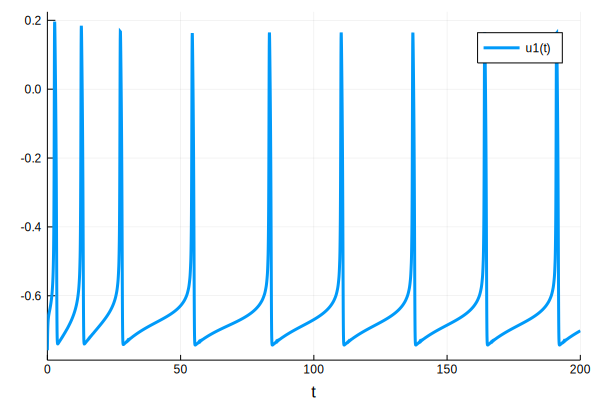

In [13]:
function Regular()
    WilsonModel(1, 26, 0.1, 5, -0.95, 0.5, 1.2, -0.95, 4.2, 14, 45)
end

model = Regular()
initial_conditions = [-1, 0., 0., 0., 0.]
tspan = (-100., 200.0)

problem = ODEProblem(equations(model), initial_conditions, tspan)
solution = solve(problem)
plot(solution, tspan=(0.0, 200.0), vars=([1]))

but can also simulate the behaviour of other types or neurons by changing the properties of the membrane and channels, such as a neuron that fires spikes very quickly

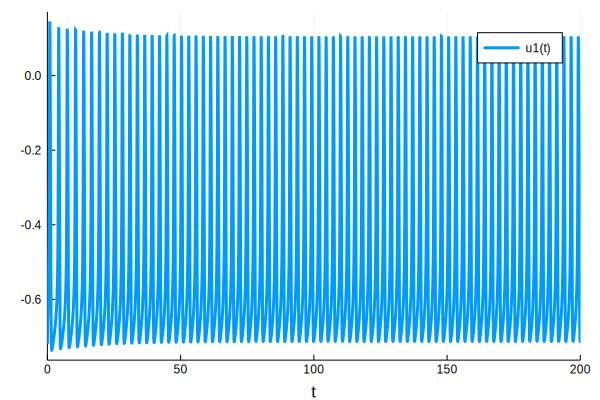

In [12]:
function Fast()
    WilsonModel(1, 26, 0.25, 0, -0.95, 0.5, 1.2, -0.95, 1.5, 14, 45)
end
    
model = Fast()
initial_conditions = [-1, 0., 0., 0., 0.]
tspan = (-100., 200.0)

problem = ODEProblem(equations(model), initial_conditions, tspan)
solution = solve(problem)
plot(solution, tspan=(0.0, 200.0), vars=([1]))

or neurons that produce bursts of spikes followed by long refractory periods

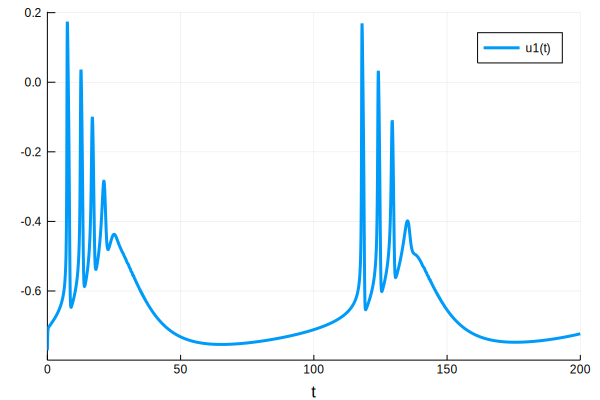

In [14]:
model = Bursting()
initial_conditions = [-1, 0., 0., 0., 0.]
tspan = (-100., 200.0)

problem = ODEProblem(equations(model), initial_conditions, tspan)
solution = solve(problem)
plot(solution, tspan=(0.0, 200.0), vars=([1]))